<a href="https://colab.research.google.com/github/manavtech07/Inventory_demand_forecasting/blob/main/stocking_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Section 1 - Setup

First, we need to mount this notebook to our Google Drive folder, in order to access the CSV data file. If you haven't already, watch this video https://www.youtube.com/watch?v=woHxvbBLarQ to help you mount your Google Drive folder.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We want to use dataframes once again to store and manipulate the data.

In [2]:
!pip install pandas

In [3]:
import pandas as pd


## Section 2 - Data loading

Similar to before, let's load our data from Google Drive for the 3 datasets provided. Be sure to upload the datasets into Google Drive, so that you can access them here.

In [5]:
path = "/content/drive/MyDrive/"

sales_df = pd.read_csv(f"{path}sales.csv")
sales_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
sales_df.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:23:58,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:32:43,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


In [6]:
stock_df = pd.read_csv(f"{path}sensor_stock_levels.csv")
stock_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
stock_df.head()

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:13:02,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:39:46,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:17:43,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:29:09,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79
4,08a32247-3f44-4002-85fb-c198434dd4bb,2022-03-02 13:46:18,7f478817-aa5b-44e9-9059-8045228c9eb0,0.22


In [7]:
temp_df = pd.read_csv(f"{path}sensor_storage_temperature.csv")
temp_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
temp_df.head()

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:55:20,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:18:22,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:12:26,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 12:30:42,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:09:33,1.38


---

## Section 4 - Data cleaning

Now that we have our 3 datasets successfully loaded, we need to ensure that the data is clean. Data cleaning can be a very intense task, so for this exercise, we will focus just on ensuring that the correct datatypes are present for each column, and if not, correcting them.

We can use the `.info()` method to look at data types.

In [8]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB


In [9]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  object 
 1   timestamp            15000 non-null  object 
 2   product_id           15000 non-null  object 
 3   estimated_stock_pct  15000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 468.9+ KB


In [10]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           23890 non-null  object 
 1   timestamp    23890 non-null  object 
 2   temperature  23890 non-null  float64
dtypes: float64(1), object(2)
memory usage: 560.0+ KB


Everything looks fine for the 3 datasets apart from the `timestamp` column in each dataset. Using the same helper function as before, let's convert this to the correct type for each dataset.

In [11]:
def convert_to_datetime(data: pd.DataFrame = None, column: str = None):

  dummy = data.copy()
  dummy[column] = pd.to_datetime(dummy[column], format='%Y-%m-%d %H:%M:%S')
  return dummy

In [12]:
sales_df = convert_to_datetime(sales_df, 'timestamp')
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  7829 non-null   object        
 1   timestamp       7829 non-null   datetime64[ns]
 2   product_id      7829 non-null   object        
 3   category        7829 non-null   object        
 4   customer_type   7829 non-null   object        
 5   unit_price      7829 non-null   float64       
 6   quantity        7829 non-null   int64         
 7   total           7829 non-null   float64       
 8   payment_type    7829 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 550.6+ KB


In [13]:
stock_df = convert_to_datetime(stock_df, 'timestamp')
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   15000 non-null  object        
 1   timestamp            15000 non-null  datetime64[ns]
 2   product_id           15000 non-null  object        
 3   estimated_stock_pct  15000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 468.9+ KB


In [14]:
temp_df = convert_to_datetime(temp_df, 'timestamp')
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           23890 non-null  object        
 1   timestamp    23890 non-null  datetime64[ns]
 2   temperature  23890 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 560.0+ KB


This looks much better!

---

## Section 5 - Merge data

Currently we have 3 datasets. In order to include all of this data within a predictive model, we need to merge them together into 1 dataframe.

If we revisit the problem statement:

```
“Can we accurately predict the stock levels of products, based on sales data and sensor data,
on an hourly basis in order to more intelligently procure products from our suppliers.”
```

The client indicates that they want the model to predict on an hourly basis. Looking at the data model, we can see that only column that we can use to merge the 3 datasets together is `timestamp`.

So, we must first transform the `timestamp` column in all 3 datasets to be based on the hour of the day, then we can merge the datasets together.

In [15]:
sales_df.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:23:58,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:32:43,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


In [16]:
from datetime import datetime

def convert_timestamp_to_hourly(data: pd.DataFrame = None, column: str = None):
  dummy = data.copy()
  new_ts = dummy[column].tolist()
  new_ts = [i.strftime('%Y-%m-%d %H:00:00') for i in new_ts]
  new_ts = [datetime.strptime(i, '%Y-%m-%d %H:00:00') for i in new_ts]
  dummy[column] = new_ts
  return dummy

In [17]:
sales_df = convert_timestamp_to_hourly(sales_df, 'timestamp')
sales_df.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:00:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:00:00,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:00:00,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:00:00,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:00:00,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


In [18]:
stock_df = convert_timestamp_to_hourly(stock_df, 'timestamp')
stock_df.head()

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:00:00,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:00:00,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:00:00,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:00:00,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79
4,08a32247-3f44-4002-85fb-c198434dd4bb,2022-03-02 13:00:00,7f478817-aa5b-44e9-9059-8045228c9eb0,0.22


In [19]:
temp_df = convert_timestamp_to_hourly(temp_df, 'timestamp')
temp_df.head()

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:00:00,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:00:00,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:00:00,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 12:00:00,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:00:00,1.38


Now you can see all of the `timestamp` columns have had the minutes and seconds reduced to `00`. The next thing to do, is to aggregate the datasets in order to combine rows which have the same value for `timestamp`.

For the `sales` data, we want to group the data by `timestamp` but also by `product_id`. When we aggregate, we must choose which columns to aggregate by the grouping. For now, let's aggregate quantity.

In [20]:
sales_agg = sales_df.groupby(['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
sales_agg.head()

,timestamp,product_id,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3
2,2022-03-01 09:00:00,03a2557a-aa12-4add-a6d4-77dc36342067,3
3,2022-03-01 09:00:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,7
4,2022-03-01 09:00:00,04da844d-8dba-4470-9119-e534d52a03a0,11


We now have an aggregated sales data where each row represents a unique combination of hour during which the sales took place from that weeks worth of data and the product_id. We summed the quantity and we took the mean average of the unit_price.

For the stock data, we want to group it in the same way and aggregate the `estimated_stock_pct`.

In [21]:
stock_agg = stock_df.groupby(['timestamp', 'product_id']).agg({'estimated_stock_pct': 'mean'}).reset_index()
stock_agg.head()

,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05


This shows us the average stock percentage of each product at unique hours within the week of sample data.

Finally, for the temperature data, product_id does not exist in this table, so we simply need to group by timestamp and aggregate the `temperature`.

In [22]:
temp_agg = temp_df.groupby(['timestamp']).agg({'temperature': 'mean'}).reset_index()
temp_agg.head()

,timestamp,temperature
0,2022-03-01 09:00:00,-0.028850
1,2022-03-01 10:00:00,1.284314
2,2022-03-01 11:00:00,-0.560000
3,2022-03-01 12:00:00,-0.537721
4,2022-03-01 13:00:00,-0.188734


This gives us the average temperature of the storage facility where the produce is stored in the warehouse by unique hours during the week. Now, we are ready to merge our data. We will use the `stock_agg` table as our base table, and we will merge our other 2 tables onto this.

In [23]:
merged_df = stock_agg.merge(sales_agg, on=['timestamp', 'product_id'], how='left')
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN


In [24]:
merged_df = merged_df.merge(temp_agg, on='timestamp', how='left')
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.02885
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.02885
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.02885


In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             3067 non-null   float64       
 4   temperature          10845 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 508.4+ KB


We can see from the `.info()` method that we have some null values. These need to be treated before we can build a predictive model. The column that features some null values is `quantity`. We can assume that if there is a null value for this column, it represents that there were 0 sales of this product within this hour. So, lets fill this columns null values with 0, however, we should verify this with the client, in order to make sure we're not making any assumptions by filling these null values with 0.

In [26]:
merged_df['quantity'] = merged_df['quantity'].fillna(0)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             10845 non-null  float64       
 4   temperature          10845 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 508.4+ KB


We can combine some more features onto this table too, including `category` and `unit_price`.

In [27]:
product_categories = sales_df[['product_id', 'category']]
product_categories = product_categories.drop_duplicates()

product_price = sales_df[['product_id', 'unit_price']]
product_price = product_price.drop_duplicates()

In [28]:
merged_df = merged_df.merge(product_categories, on="product_id", how="left")
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,kitchen
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,vegetables
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.02885,baby products
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.02885,beverages
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.02885,pets


In [29]:
merged_df = merged_df.merge(product_price, on="product_id", how="left")
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,kitchen,11.19
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,vegetables,1.49
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.02885,baby products,14.19
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.02885,beverages,20.19
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.02885,pets,8.19


In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             10845 non-null  float64       
 4   temperature          10845 non-null  float64       
 5   category             10845 non-null  object        
 6   unit_price           10845 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 677.8+ KB


Now we have our table with 2 extra features!

---

## Section 6 - Feature engineering

We have our cleaned and merged data. Now we must transform this data so that the columns are in a suitable format for a machine learning model. In other terms, every column must be numeric. There are some models that will accept categorical features, but for this exercise we will use a model that requires numeric features.

Let's first engineer the `timestamp` column. In it's current form, it is not very useful for a machine learning model. Since it's a datetime datatype, we can explode this column into day of week, day of month and hour to name a few.

In [31]:
merged_df['timestamp_day_of_month'] = merged_df['timestamp'].dt.day
merged_df['timestamp_day_of_week'] = merged_df['timestamp'].dt.dayofweek
merged_df['timestamp_hour'] = merged_df['timestamp'].dt.hour
merged_df.drop(columns=['timestamp'], inplace=True)
merged_df.head()

,product_id,estimated_stock_pct,quantity,temperature,category,unit_price,timestamp_day_of_month,timestamp_day_of_week,timestamp_hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,kitchen,11.19,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,vegetables,1.49,1,1,9
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.02885,baby products,14.19,1,1,9
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.02885,beverages,20.19,1,1,9
4,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.02885,pets,8.19,1,1,9


The next column that we can engineer is the `category` column. In its current form it is categorical. We can convert it into numeric by creating dummy variables from this categorical column.

A dummy variable is a binary flag column (1's and 0's) that indicates whether a row fits a particular value of that column. For example, we can create a dummy column called category_pets, which will contain a 1 if that row indicates a product which was included within this category and a 0 if not.

In [32]:
merged_df = pd.get_dummies(merged_df, columns=['category'])
merged_df.head()

,product_id,estimated_stock_pct,quantity,temperature,unit_price,timestamp_day_of_month,timestamp_day_of_week,timestamp_hour,category_baby products,category_baked goods,...,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,11.19,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,1.49,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,1
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.02885,14.19,1,1,9,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.02885,20.19,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.02885,8.19,1,1,9,0,0,...,0,0,0,0,1,0,0,0,0,0


In [33]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   product_id                      10845 non-null  object 
 1   estimated_stock_pct             10845 non-null  float64
 2   quantity                        10845 non-null  float64
 3   temperature                     10845 non-null  float64
 4   unit_price                      10845 non-null  float64
 5   timestamp_day_of_month          10845 non-null  int64  
 6   timestamp_day_of_week           10845 non-null  int64  
 7   timestamp_hour                  10845 non-null  int64  
 8   category_baby products          10845 non-null  uint8  
 9   category_baked goods            10845 non-null  uint8  
 10  category_baking                 10845 non-null  uint8  
 11  category_beverages              10845 non-null  uint8  
 12  category_canned foods           

Looking at the latest table, we only have 1 remaining column which is not numeric. This is the `product_id`.

Since each row represents a unique combination of product_id and timestamp by hour, and the product_id is simply an ID column, it will add no value by including it in the predictive model. Hence, we shall remove it from the modeling process.

In [34]:
merged_df.drop(columns=['product_id'], inplace=True)
merged_df.head()

,estimated_stock_pct,quantity,temperature,unit_price,timestamp_day_of_month,timestamp_day_of_week,timestamp_hour,category_baby products,category_baked goods,category_baking,...,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,0.89,3.0,-0.02885,11.19,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.14,3.0,-0.02885,1.49,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.67,0.0,-0.02885,14.19,1,1,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.82,0.0,-0.02885,20.19,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.05,0.0,-0.02885,8.19,1,1,9,0,0,0,...,0,0,0,0,1,0,0,0,0,0


This feature engineering was by no means exhaustive, but was enough to give you an example of the process followed when engineering the features of a dataset. In reality, this is an iterative task. Once you've built a model, you may have to revist feature engineering in order to create new features to boost the predictive power of a machine learning model.

---

## Section 7 - Modelling

Now it is time to train a machine learning model. We will use a supervised machine learning model, and we will use `estimated_stock_pct` as the target variable, since the problem statement was focused on being able to predict the stock levels of products on an hourly basis.

Whilst training the machine learning model, we will use cross-validation, which is a technique where we hold back a portion of the dataset for testing in order to compute how well the trained machine learning model is able to predict the target variable.

Finally, to ensure that the trained machine learning model is able to perform robustly, we will want to test it several times on random samples of data, not just once. Hence, we will use a `K-fold` strategy to train the machine learning model on `K` (K is an integer to be decided) random samples of the data.

First, let's create our target variable `y` and independent variables `X`

In [35]:
X = merged_df.drop(columns=['estimated_stock_pct'])
y = merged_df['estimated_stock_pct']
print(X.shape)
print(y.shape)

(10845, 28)
(10845,)


This shows that we have 29 predictor variables that we will train our machine learning model on and 10845 rows of data.

Now let's define how many folds we want to complete during training, and how much of the dataset to assign to training, leaving the rest for test.

Typically, we should leave at least 20-30% of the data for testing.

In [36]:
K = 10
split = 0.75

For this exercise, we are going to use a `RandomForestRegressor` model, which is an instance of a Random Forest. These are powerful tree based ensemble algorithms and are particularly good because their results are very interpretable.

We are using a `regression` algorithm here because we are predicting a continuous numeric variable, that is, `estimated_stock_pct`. A `classification` algorithm would be suitable for scenarios where you're predicted a binary outcome, e.g. True/False.

We are going to use a package called `scikit-learn` for the machine learning algorithm, so first we must install and import this, along with some other functions and classes that can help with the evaluation of the model.

In [37]:
!pip install scikit-learn

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

And now let's create a loop to train `K` models with a 75/25% random split of the data each time between training and test samples

In [39]:
accuracy = []

for fold in range(0, K):

  # Instantiate algorithm
  model = RandomForestRegressor()
  scaler = StandardScaler()

  # Create training and test samples
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split, random_state=42)

  # Scale X data, we scale the data because it helps the algorithm to converge
  # and helps the algorithm to not be greedy with large values
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  # Train model
  trained_model = model.fit(X_train, y_train)

  # Generate predictions on test sample
  y_pred = trained_model.predict(X_test)

  # Compute accuracy, using mean absolute error
  mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
  accuracy.append(mae)
  print(f"Fold {fold + 1}: MAE = {mae:.3f}")

print(f"Average MAE: {(sum(accuracy) / len(accuracy)):.2f}")


Fold 1: MAE = 0.236
Fold 2: MAE = 0.237
Fold 3: MAE = 0.237
Fold 4: MAE = 0.235
Fold 5: MAE = 0.236
Fold 6: MAE = 0.237
Fold 7: MAE = 0.236
Fold 8: MAE = 0.236
Fold 9: MAE = 0.237
Fold 10: MAE = 0.237
Average MAE: 0.24


Note, the output of this training loop may be slightly different for you if you have prepared the data differently or used different parameters!

This is very interesting though. We can see that the `mean absolute error` (MAE) is almost exactly the same each time. This is a good sign, it shows that the performance of the model is consistent across different random samples of the data, which is what we want. In other words, it shows a robust nature.

The `MAE` was chosen as a performance metric because it describes how closely the machine learning model was able to predict the exact value of `estimated_stock_pct`.

Even though the model is predicting robustly, this value for MAE is not so good, since the average value of the target variable is around 0.51, meaning that the accuracy as a percentage was around 50%. In an ideal world, we would want the MAE to be as low as possible. This is where the iterative process of machine learning comes in. At this stage, since we only have small samples of the data, we can report back to the business with these findings and recommend that the the dataset needs to be further engineered, or more datasets need to be added.

As a final note, we can use the trained model to intepret which features were signficant when the model was predicting the target variable. We will use `matplotlib` and `numpy` to visualuse the results, so we should install and import this package.

In [40]:
!pip install matplotlib
!pip install numpy

In [41]:
import matplotlib.pyplot as plt
import numpy as np

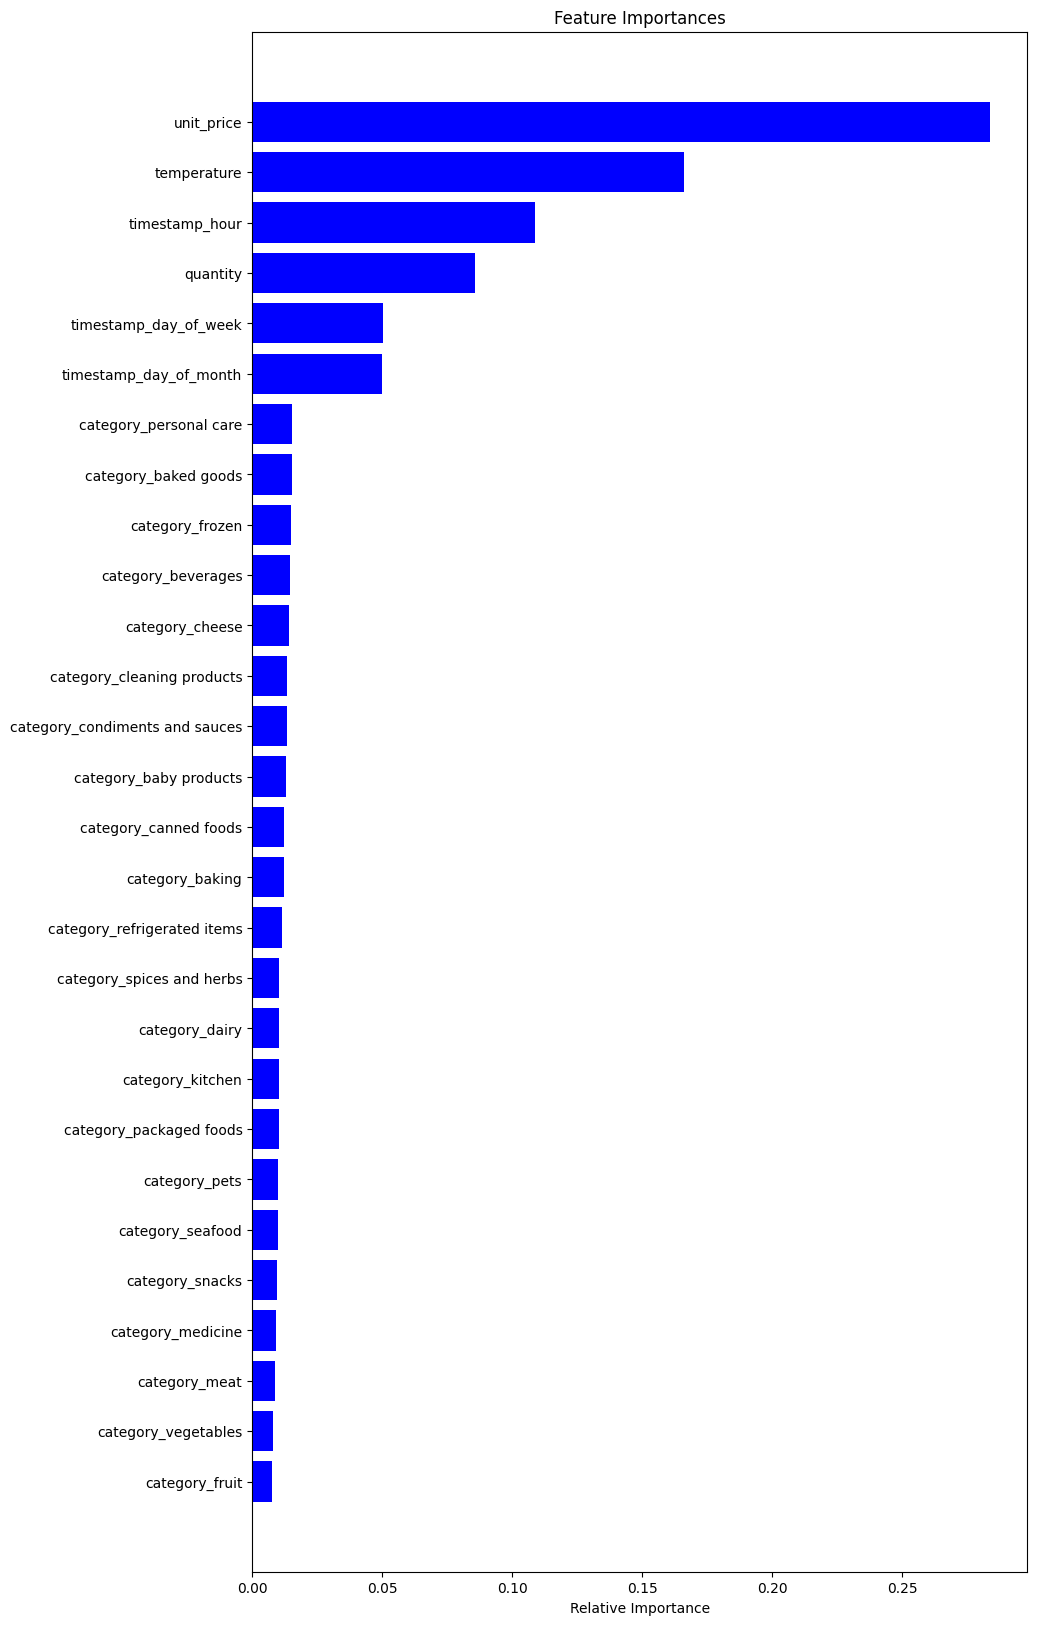

In [42]:
features = [i.split("__")[0] for i in X.columns]
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

This feature importance visualisation tells us:

- The product categories were not that important
- The unit price and temperature were important in predicting stock
- The hour of day was also important for predicting stock

With these insights, we can now report this back to the business